In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Data Description

The dataset contains 65,532 network traffic logs, capturing detailed connection information between various source and destination ports. It consists of 12 attributes that describe network activity, data transmission, and packet exchange. This dataset can be used to analyze network behavior, detect anomalies, and identify potential cyber threats.

Each record in the dataset represents an individual network connection and includes the following details:

1. Source Port: The port number used by the sender (client) to start the connection. It’s often a random high-numbered port.
2. Destination Ports: The port number on the receiver’s (server’s) side. This usually indicates the type of service being requested.
3. NAT Source: Network Address Translation (NAT) modifies the source port when traffic leaves a private network. This shows the port used after translation by the firewall/router.
4. NAT Destination Ports: This is the translated destination port as seen by the internal firewall or NAT device.
5. Action: Specifies whether the connection was allowed or denied by the firewall. 
6. Bytes: The total number of bytes (data) transferred in the entire session (sent + received).
7. Bytes Sent: The amount of data sent by the source (outgoing traffic).
8. Bytes Received: The amount of data received by the source (incoming traffic).
9. Packets: The total number of packets exchanged. Data is split into small "packets" for transmission over the internet.
10. Elapsed Time (sec): The duration of the connection, in seconds. Very long or very short times can signal abnormal behavior (e.g. persistent threats or failed connections).
11. pkts_sent: The number of packets sent by the source device.
12. pkts_received: The number of packets received by the source device.

Using this dataset, I aim to explore and uncover cybersecurity threats by analyzing patterns in network traffic. Rather than focusing on predefined attack types, this project adopts a data-driven, investigative approach to identify potential indicators of malicious behavior.

In particular, I seek to:
- Explore anomalies in traffic patterns, including spikes in denied traffic, unusually high packet exchanges, or irregular data transfers.
- Examine connection behaviors that may suggest port scanning, brute-force attempts, or unauthorized access efforts.
- Investigate data flows that could indicate risks of data exfiltration, especially those with disproportionately high outbound traffic.
- Analyze temporal trends and traffic volume fluctuations that might signal coordinated or stealthy intrusions.
- Apply clustering and other unsupervised learning techniques to differentiate between normal and potentially malicious activity.

UCI: [Internet Firewall Data](https://archive.ics.uci.edu/dataset/542/internet+firewall+data)

# Importing Dataset and Basic Information about the Dataset

In [4]:
# https://archive.ics.uci.edu/dataset/542/internet+firewall+data
df = pd.read_csv("traffic_log.csv")
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [8]:
df.describe()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.000000,65532.000000,65532.000000,65532.000000,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,49391.969343,10577.385812,19282.972761,2671.049930,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,15255.712537,18466.027039,21970.689669,9739.162278,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,49183.000000,80.000000,0.000000,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,53776.500000,445.000000,8820.500000,53.000000,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,58638.000000,15000.000000,38366.250000,443.000000,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,65534.000000,65535.000000,65535.000000,65535.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


# Data Cleaning & Understanding Data

## Are there any duplicate records in the dataset? If so, do they suggest incomplete attack logs or corrupted data entries?

In [10]:
# Extract the duplicated data from the dataset
duplicates = df[df.duplicated() == True]
print(f"There are in total {len(duplicates)} rows of data in the dataset.")

There are in total 8362 rows of data in the dataset.


At first glance, duplicate rows in a dataset might seem like a mistake or something to delete. But in cybersecurity, they can actually reveal suspicious or malicious behavior.

For example, if many logs show the exact same traffic with zero bytes transferred and an elapsed time of zero seconds, it could mean something tried to connect but failed — possibly a hacker scanning the network.

Therefore, instead of blindly deleting them, I need to check whether these duplicates are signs of failed attacks or truly useless data.

In [12]:
# Check how many duplicates have zero bytes or packets (possibly incomplete connections)
incomplete_logs = duplicates[
    (duplicates['Bytes'] == 0) |
    (duplicates['Packets'] == 0) |
    (duplicates['Elapsed Time (sec)'] == 0)
]

# Summary statistics
total_duplicates = len(duplicates)
incomplete_count = len(incomplete_logs)
incomplete_percentage = (incomplete_count / total_duplicates) * 100

# Decision threshold: if more than 20% seem incomplete, we keep them
decision = "KEEP" if incomplete_percentage > 20 else "DROP"

{
    "total_duplicate_rows": total_duplicates,
    "incomplete_attack_like_rows": incomplete_count,
    "percent_potentially_incomplete": f"{incomplete_percentage:.2f}%",
    "recommended_action": decision
}

{'total_duplicate_rows': 8362,
 'incomplete_attack_like_rows': 8231,
 'percent_potentially_incomplete': '98.43%',
 'recommended_action': 'KEEP'}

There are 98.43% of the data are considered as failed attac attempts. If a large percentage (e.g., >20%) of duplicates show signs of being incomplete, they could reflect repeated failed attack attempts. Therefore, we should consider to keep the duplicated rows. 

## How frequently does each Action type (e.g., allow, deny) occur? How many activities are treated as suspicious activities by the firewall?

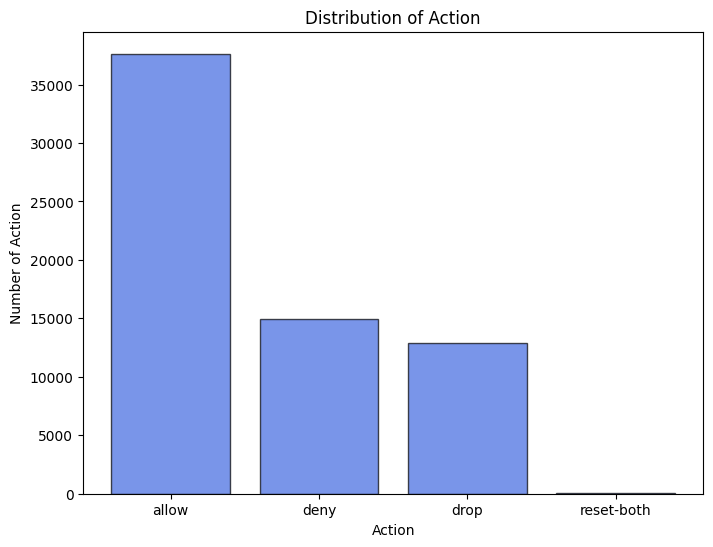

In [14]:
action_counts = df["Action"].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(action_counts.index, action_counts.values, color='royalblue', edgecolor='black', alpha=0.7)
plt.xlabel("Action")
plt.ylabel("Number of Action")
plt.title("Distribution of Action")
plt.xticks()

plt.show()

- allow: The connection was permitted by the firewall. This usually means it met all the required rules and passed security checks.
- deny: The connection was explicitly blocked by the firewall. This could indicate unauthorized access attempts, misconfigured clients, or traffic from suspicious sources.
- drop: The packet was silently discarded with no response sent back to the sender. This technique is often used to avoid giving attackers clues that their connection was blocked (commonly used against port scans or brute-force attempts).
- reset-both: The firewall sent TCP reset (RST) packets to both ends of the connection to forcibly terminate it. This typically happens when an existing connection is deemed suspicious or violates session integrity.

The firewall allowed 37640 connections, denied 14987 connections, dropped 12851 connections, and reset both 54 connection.

In [16]:
# Create a separate dataframe for suspicious activities
sus_df = df[df['Action'] != 'allow']
print(f"There are {len(sus_df)} activities that the firewall detected and treated as suspicious activities.")

There are 27892 activities that the firewall detected and treated as suspicious activities.


## Do any source ports or destination ports have incorrect or unexpected values?

First, well-known ports are defined by using IANA's commonly accepted port range rules:
- 0-1023: Well-known ports (assigned and controlled)
- 1024-49151: Registered ports (used by software vendors)
- 49152-65535: Dynamic/private ports (ephemeral)

In [18]:
source_port_stats = df['Source Port'].value_counts().reset_index()
source_port_stats.columns = ['Port', 'Count']
source_port_stats['Type'] = pd.cut(source_port_stats['Port'], 
                                   bins=[-1, 1023, 49151, 65535],
                                   labels=['Well-known', 'Registered', 'Dynamic'])

dest_port_stats = df['Destination Port'].value_counts().reset_index()
dest_port_stats.columns = ['Port', 'Count']
dest_port_stats['Type'] = pd.cut(dest_port_stats['Port'], 
                                 bins=[-1, 1023, 49151, 65535],
                                 labels=['Well-known', 'Registered', 'Dynamic'])

In [20]:
print("Top 10 Most Common Source Ports:")
source_port_stats.sort_values(by='Count', ascending=False).head(10)

Top 10 Most Common Source Ports:


,Port,Count,Type
0,58638,840,Dynamic
1,27005,513,Registered
2,443,273,Well-known
3,57470,222,Dynamic
4,49418,210,Dynamic
5,6881,177,Registered
6,0,173,Well-known
7,50584,116,Dynamic
8,3478,105,Registered
9,26900,102,Registered


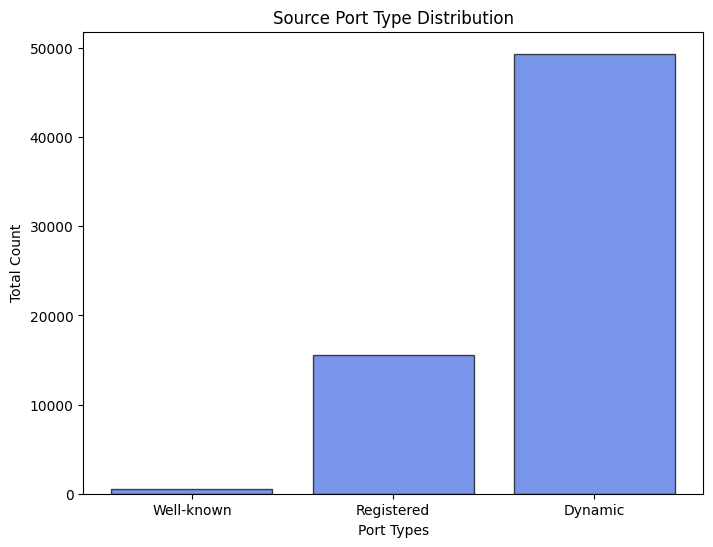

In [22]:
source_port_group = source_port_stats.groupby('Type')['Count'].sum().reset_index()

plt.figure(figsize=(8, 6))
plt.bar(source_port_group['Type'], source_port_group['Count'], color='royalblue', edgecolor='black', alpha=0.7)
plt.xlabel("Port Types")
plt.ylabel("Total Count")
plt.title("Source Port Type Distribution")
plt.xticks()

plt.show()

In [24]:
print("Top 10 Most Common Destination Ports:")
dest_port_stats.sort_values(by='Count', ascending=False).head(10)

Top 10 Most Common Destination Ports:


,Port,Count,Type
0,53,15414,Well-known
1,445,12891,Well-known
2,443,11684,Well-known
3,80,4035,Well-known
4,25174,1087,Registered
5,5900,909,Registered
6,37965,826,Registered
7,22114,767,Registered
8,64147,756,Dynamic
9,50584,717,Dynamic


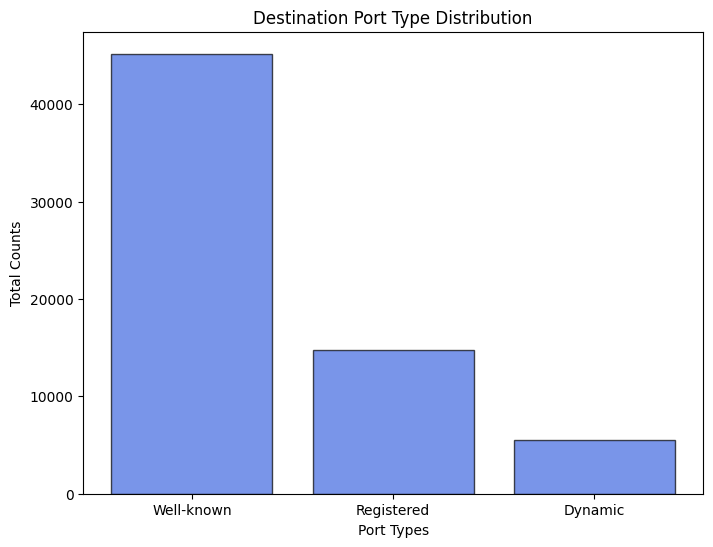

In [26]:
dest_port_group = dest_port_stats.groupby('Type')['Count'].sum().reset_index()

plt.figure(figsize=(8, 6))
plt.bar(dest_port_group['Type'], dest_port_group['Count'], color='royalblue', edgecolor='black', alpha=0.7)
plt.xlabel("Port Types")
plt.ylabel("Total Counts")
plt.title("Destination Port Type Distribution")
plt.xticks()

plt.show()

The analysis of source and destination ports revealed the following:
- Many high-frequency source ports are in the dynamic range (e.g., 58638, 57470), which is normal for ephemeral client-side ports.
- Port 0 appears as a source port 173 times, which is abnormal. Port 0 is reserved and should not be used in valid TCP/IP communication—it may indicate malformed packets or scanning attempts.
- While standard web and file-sharing destination ports like 443, 445, 80, and 53 dominate as expected, ports like 25174, 64147, and 50584 are frequent yet non-standard, possibly suggesting use of custom or obscure services, attempts to bypass firewalls by using high, unmonitored ports, or malicious behavior (e.g., C2 servers or exfiltration channels).

In summary, source port 0 usage is a strong candidate for malicious or scanning behavior. Frequent access to non-standard high destination ports may signal attempts to exploit uncommon services or avoid detection.

## Are there any connections where Bytes Sent or Bytes Received is zero, yet a high number of packets were exchanged?

In [28]:
# Let's consider "high number of Packets" as more than a threshold, say 10 packets
zero_and_high = df[((df['Bytes Sent'] == 0) | (df['Bytes Received'] == 0)) & (df['pkts_sent'] > 10)]
zero_and_high

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
3481,46593,28678,34181,28678,allow,1806,1806,0,22,224,22,0
4466,38474,28678,45201,28678,allow,1806,1806,0,22,224,22,0
5909,50265,54145,30228,54145,allow,858,858,0,14,1200,14,0
5933,57470,31373,26422,31373,allow,1386,1386,0,22,1798,22,0
6671,57470,1930,53151,1930,allow,858,858,0,14,1199,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...
61063,57470,31381,16195,31381,allow,792,792,0,13,1200,13,0
61555,15503,11731,3627,11731,allow,1188,1188,0,19,2298,19,0
62527,58677,28678,3047,28678,allow,1806,1806,0,22,225,22,0
62606,40521,28678,47764,28678,allow,1806,1806,0,22,225,22,0


In the analysis of the connection logs, there is a pattern of network activity where either "Bytes Sent" or "Bytes Received" was zero, yet the number of packets exchanged was unusually high, in some cases exceeding 70 packets. The vast majority of these cases involved non-zero Bytes Sent and zero Bytes Received, suggesting that the source system was actively sending data but not receiving any response.

These connections also involved high packet counts, indicating repeated communication attempts. The pkts_received column confirms that no packets were returned, supporting the idea of one-sided traffic.

This traffic behavior may reflect unsuccessful brute-force attacks or network scanning attempts, where an external or internal source tries to interact with multiple destinations but receives no reply, potentially due to blocked ports, non-existent services, or active defense mechanisms.

## Are there unusual or repetitive NAT Source or Destination Port values？

In [30]:
# Check top 10 most frequent NAT Source Ports
top_nat_source_ports = df['NAT Source Port'].value_counts().head(10)
top_nat_source_ports

NAT Source Port
0        28432
48817       83
58638       51
50116       15
7986         5
30399        5
43757        5
57880        5
57596        5
60868        5
Name: count, dtype: int64

In [32]:
# Check top 10 most frequent NAT Destination Ports
top_nat_dest_ports = df['NAT Destination Port'].value_counts().head(10)
top_nat_dest_ports

NAT Destination Port
0        28432
53       15094
443      11678
80        4028
27015      234
27017      160
123        156
3389       156
6881       143
5228       100
Name: count, dtype: int64

Most NAT Source and Destination Ports are unique, as expected in typical NAT behavior where ephemeral ports are dynamically assigned. However, a few NAT ports are reused hundreds of times, which is unusual and may suggest:
- Persistent outbound sessions using the same translated port
- Misconfigured NAT settings causing overuse
- Scanning attempts repeatedly routed through the same NAT mapping

While NAT typically randomizes ports to avoid detection, repeated reuse of certain NAT ports may indicate scripted activity, long-lived sessions, or attempts to camouflage malicious behavior behind predictable port numbers.

# Time Series Analysis

## Plot a time series graph of denied vs. allowed traffic—are there bursts of denied traffic that might indicate an ongoing cyberattack?

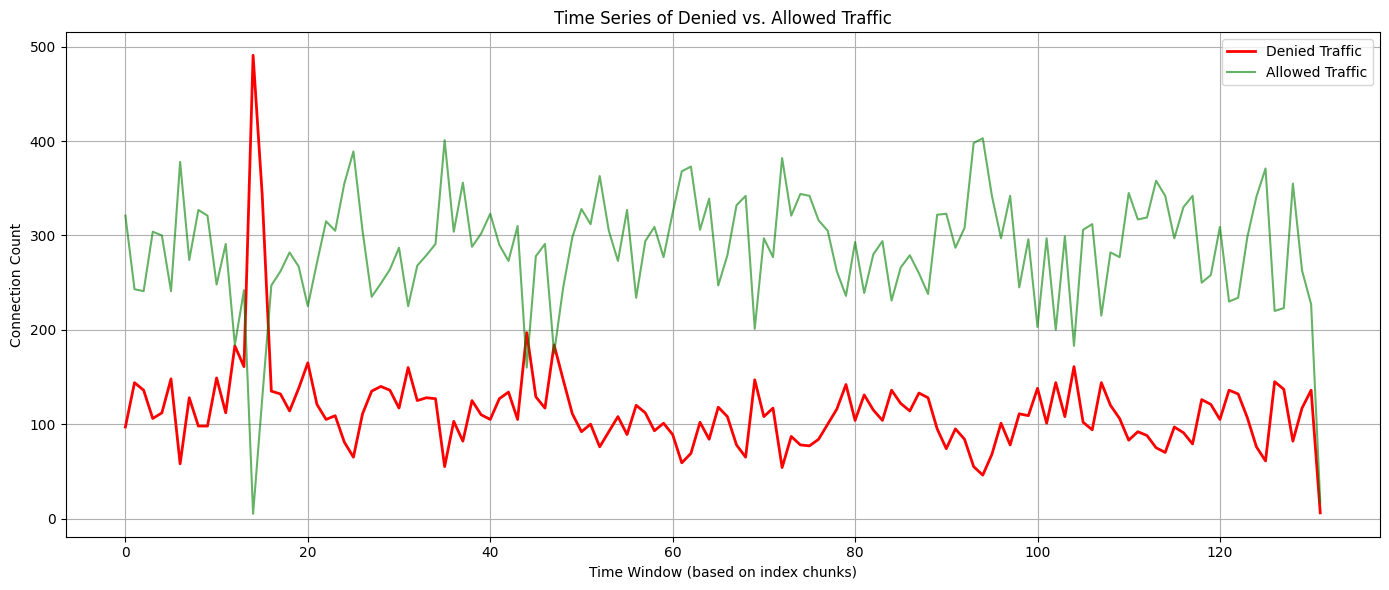

In [36]:
# Reload the dataset
df = pd.read_csv('traffic_log.csv')

# Create time index using original index as proxy for time
df['Time Index'] = df.index

# Define deny/allow flags
df['Is Denied'] = df['Action'].str.lower() == 'deny'
df['Is Allowed'] = df['Action'].str.lower() == 'allow'

# Group data in pseudo-time windows (e.g., every 500 entries)
df['Time Window'] = (df['Time Index'] // 500)

# Aggregate the counts per window
traffic_summary = df.groupby('Time Window').agg({
    'Is Denied': 'sum',
    'Is Allowed': 'sum'
}).reset_index()

# Plot the time series
plt.figure(figsize=(14, 6))
plt.plot(traffic_summary['Time Window'], traffic_summary['Is Denied'], label='Denied Traffic', color='red', linewidth=2)
plt.plot(traffic_summary['Time Window'], traffic_summary['Is Allowed'], label='Allowed Traffic', color='green', alpha=0.6)
plt.title("Time Series of Denied vs. Allowed Traffic")
plt.xlabel("Time Window (based on index chunks)")
plt.ylabel("Connection Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The time series chart visualizes the volume of denied and allowed network connections across sequential time windows.

Key Findings:
- One prominent burst of denied traffic is visible early in the timeline—a sharp spike in the red line (Denied Traffic).
- This spike suggests a potential cyberattack attempt, such as a brute-force login or port scan being blocked by firewall rules.
- Throughout the rest of the timeline, denied traffic remains consistently lower than allowed traffic, with no further significant bursts.
- Allowed traffic (green line) maintains a steady, fluctuating pattern, likely representing normal background or user-initiated activity.

The single burst of denied traffic could indicate a concentrated attack phase, possibly followed by the attacker switching strategies or being blocked effectively.

The time window where this burst occurs is worth investigating further—e.g., analyzing source IPs, ports, and payload sizes.

## Who was responsible for the denied traffic spike, and what were they targeting? Did these sources reappear later, change behavior, or succeed in gaining access?

In [34]:
# Step 1: Filter spike window (manually define or based on index range from the chart)
spike_df = df.iloc[15_000:17_000]  # adjust range based on spike location

# Step 2: Focus only on denied traffic
denied_spike = spike_df[spike_df['Action'] != 'allow']

# Step 3: Most frequent source and destination ports
top_sources = denied_spike['Source Port'].value_counts().head(10)
top_dest_ports = denied_spike['Destination Port'].value_counts().head(10)

# Step 4: See if those top source ports reappear in allowed traffic after the spike
post_spike = df.iloc[17_000:]
reappear_sources = post_spike[post_spike['Source Port'].isin(top_sources.index) & (post_spike['Action'] == 'allow')]

# Summary
print("Top Sources During Spike:\n", top_sources)
print("Top Target Ports:\n", top_dest_ports)
print("Reappearing Sources in Allowed Traffic:\n", reappear_sources['Source Port'].value_counts())

Top Sources During Spike:
 Source Port
443      8
5228     5
51490    4
11136    4
42344    4
63385    3
42030    3
58627    3
30304    3
63213    3
Name: count, dtype: int64
Top Target Ports:
 Destination Port
445      411
25174    108
22114     60
37965     37
50584     21
26467     19
64147     18
57470     14
44847     12
23        11
Name: count, dtype: int64
Reappearing Sources in Allowed Traffic:
 Source Port
443      4
51490    1
Name: count, dtype: int64


## Develop a dashboard visualization that highlights real-time attack detection metrics, such as unusual traffic spikes, high port activity, and frequent connection failures.

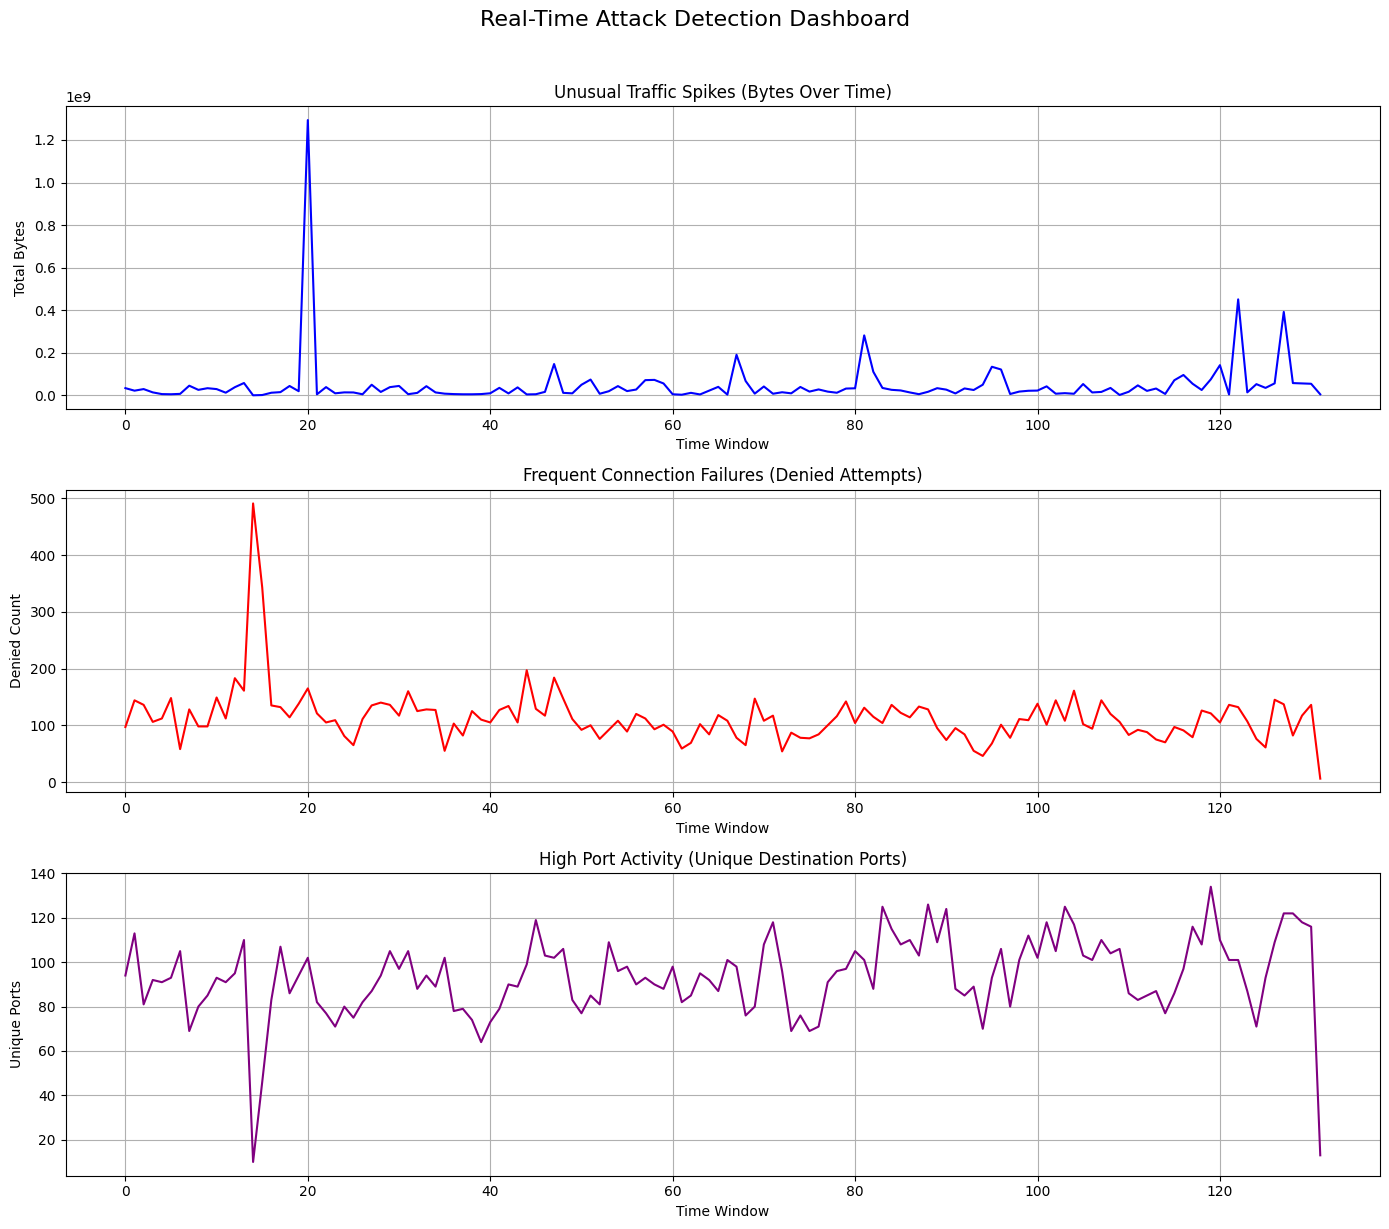

In [38]:
# Reload the dataset
df = pd.read_csv('traffic_log.csv')

# Create necessary metrics
df['Time Index'] = df.index
df['Is Denied'] = df['Action'].str.lower() == 'deny'
df['Time Window'] = (df['Time Index'] // 500)

# Metrics for dashboard
traffic_summary = df.groupby('Time Window').agg({
    'Bytes': 'sum',
    'Is Denied': 'sum',
    'Destination Port': pd.Series.nunique
}).reset_index()
traffic_summary.columns = ['Time Window', 'Total Bytes', 'Denied Connections', 'Unique Destination Ports']

# Set up the dashboard layout
fig, axs = plt.subplots(3, 1, figsize=(14, 12))
fig.suptitle("Real-Time Attack Detection Dashboard", fontsize=16, y=1.02)

# 1. Unusual traffic spikes
sns.lineplot(ax=axs[0], data=traffic_summary, x='Time Window', y='Total Bytes', color='blue')
axs[0].set_title("Unusual Traffic Spikes (Bytes Over Time)")
axs[0].set_ylabel("Total Bytes")
axs[0].grid(True)

# 2. High connection failure rate
sns.lineplot(ax=axs[1], data=traffic_summary, x='Time Window', y='Denied Connections', color='red')
axs[1].set_title("Frequent Connection Failures (Denied Attempts)")
axs[1].set_ylabel("Denied Count")
axs[1].grid(True)

# 3. Unique destination ports (High port activity)
sns.lineplot(ax=axs[2], data=traffic_summary, x='Time Window', y='Unique Destination Ports', color='purple')
axs[2].set_title("High Port Activity (Unique Destination Ports)")
axs[2].set_ylabel("Unique Ports")
axs[2].set_xlabel("Time Window")
axs[2].grid(True)

plt.tight_layout()
plt.show()

This dashboard visualizes key indicators of suspicious network activity over time:

1. Unusual Traffic Spikes
   - The top graph tracks total bytes transferred per time window.
   - A couple of distinct spikes suggest potential data exfiltration or bulk traffic events, possibly from malware or unauthorized transfers.

2. Frequent Connection Failures
   - The second chart shows denied connection counts.
   - A noticeable burst of denied attempts could indicate brute-force attacks, scanner sweeps, or malicious probing being actively blocked.

3. High Port Activity
   - The bottom graph plots the number of unique destination ports contacted over time.
   - Peaks here suggest port scanning activity or attempts to evade detection by distributing traffic across many endpoints.



# Cyberattack Visualization

## Do any combinations of source and destination ports appear frequently?

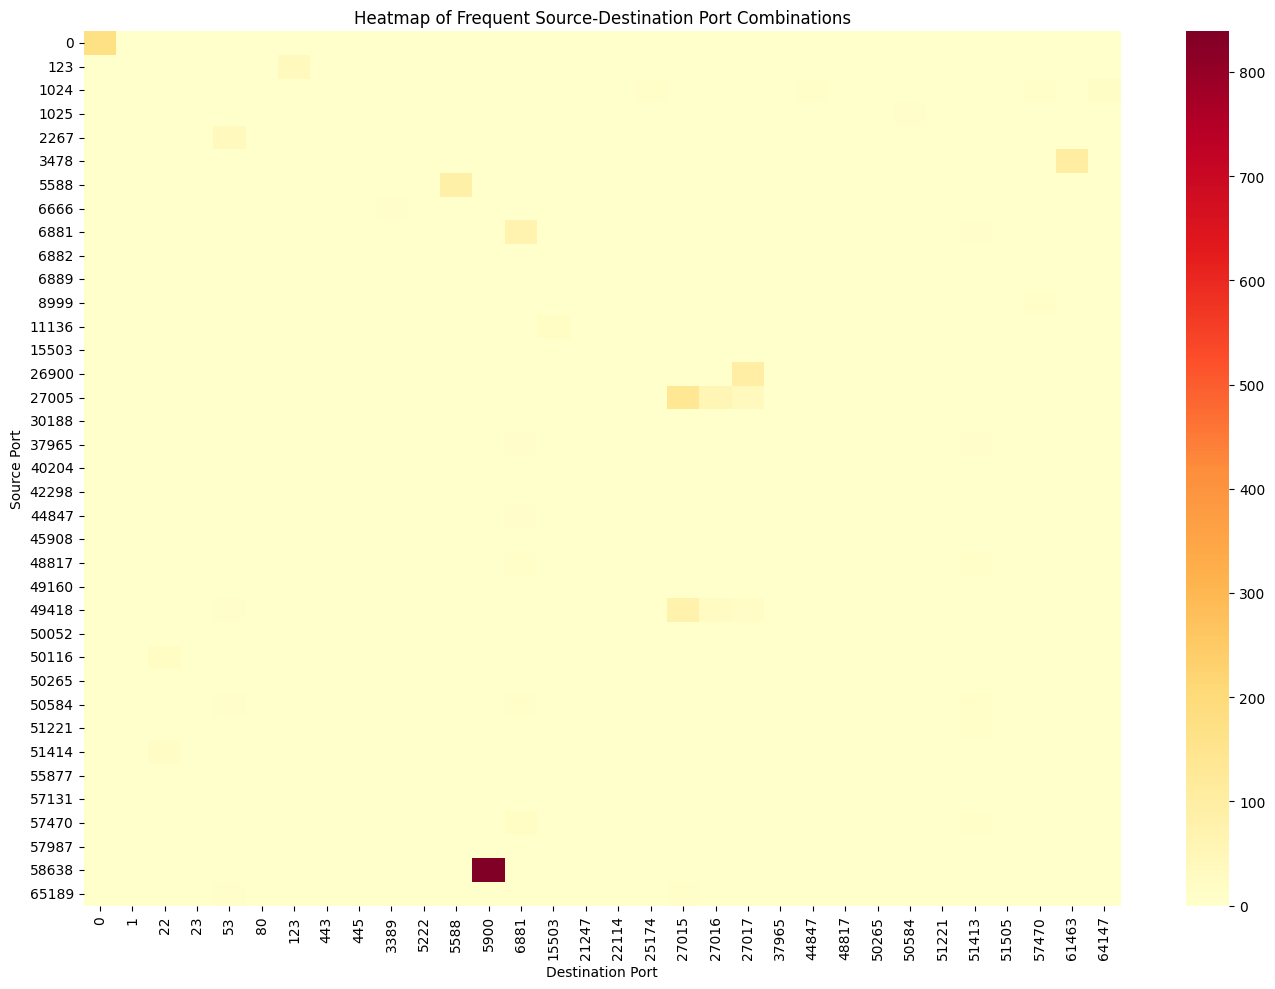

In [40]:
# Retry with filtered data to avoid memory error: select only top 50 source and destination ports first
top_src_ports = df['Source Port'].value_counts().head(50).index
top_dst_ports = df['Destination Port'].value_counts().head(50).index

filtered_df = df[df['Source Port'].isin(top_src_ports) & df['Destination Port'].isin(top_dst_ports)]

# Create the pivot table again with reduced size
port_heatmap_matrix = filtered_df.pivot_table(index='Source Port', 
                                              columns='Destination Port', 
                                              values='Packets', 
                                              aggfunc='count', 
                                              fill_value=0)

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(port_heatmap_matrix, annot=False, cmap='YlOrRd')
plt.title("Heatmap of Frequent Source-Destination Port Combinations")
plt.xlabel("Destination Port")
plt.ylabel("Source Port")
plt.tight_layout()
plt.show()

This heatmap visualizes the most frequent pairings between source and destination ports based on packet count.

Key Insights:
- Concentration of Activity: A few source-destination port combinations dominate the traffic—especially:
- Source Port 58638 → Destination Port 5228, with an intense spike (dark red).
- Ports like 27005, 6881, 49160 also appear frequently.

Evidence of Automation:
- Repeated use of the same port pairs across many sessions suggests automated scripts or malware behavior.
- These could represent command-and-control channels, brute-force agents, or scanner tools.

Suspicious Use of Non-Standard Ports: Many of the involved ports are high-numbered dynamic ports, which are often used to evade firewall detection or obfuscate attacks.

## Compare packet size distribution—are there clusters of unusually small or large packets?

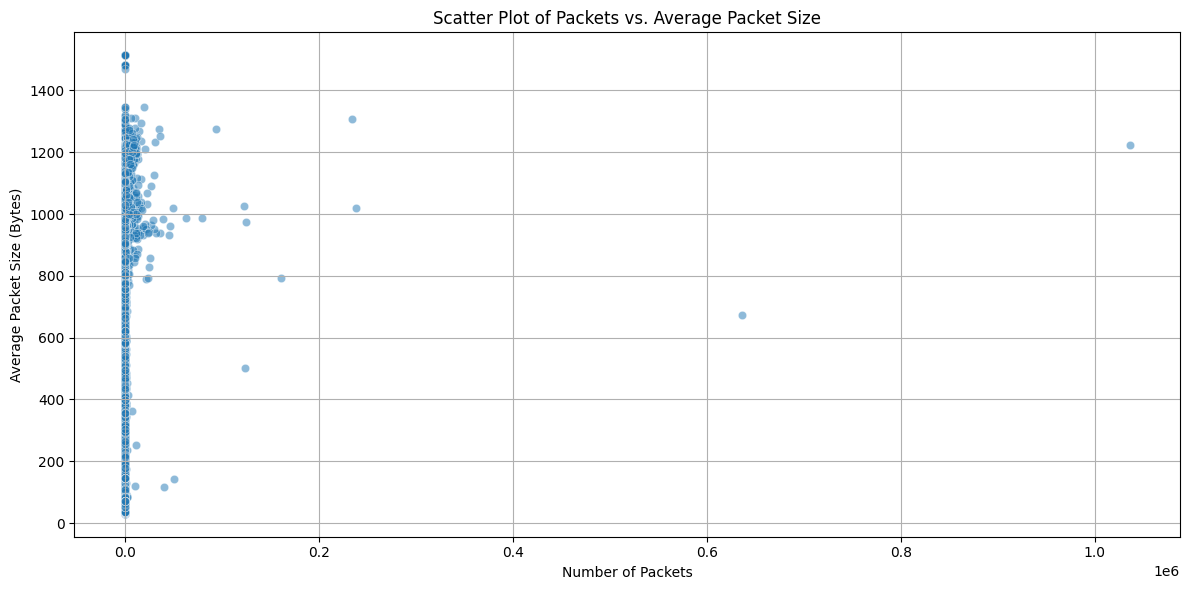

In [42]:
# Create a new column for average packet size
df['Avg Packet Size'] = df['Bytes'] / (df['Packets'] + 1e-5)

# Plot scatter plot of Packets vs. Avg Packet Size
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Packets', y='Avg Packet Size', alpha=0.5)
plt.title("Scatter Plot of Packets vs. Average Packet Size")
plt.xlabel("Number of Packets")
plt.ylabel("Average Packet Size (Bytes)")
plt.grid(True)
plt.tight_layout()
plt.show()

This scatter plot compares the number of packets with the average size of each packet in bytes for each network session.

Tight Clusters of Small Packets:
- There's a dense group with fewer than 50 packets and very small average packet sizes (< 100 bytes).
- This could represent heartbeat signals, scanner probes, or tunneling behavior designed to stay under detection thresholds.

Outliers with Large Packet Sizes: A few points show unusually high average packet sizes, even with a small number of packets—possible signs of bulk data exfiltration.

Mid-Range Distribution:Most traffic seems to follow a normal curve, balancing packet count and size, likely representing standard application traffic.

This kind of visualization is especially helpful in spotting tunneling, low-and-slow exfiltration, or anomalous protocol misuse.

## What are the most frequently targeted destination ports?

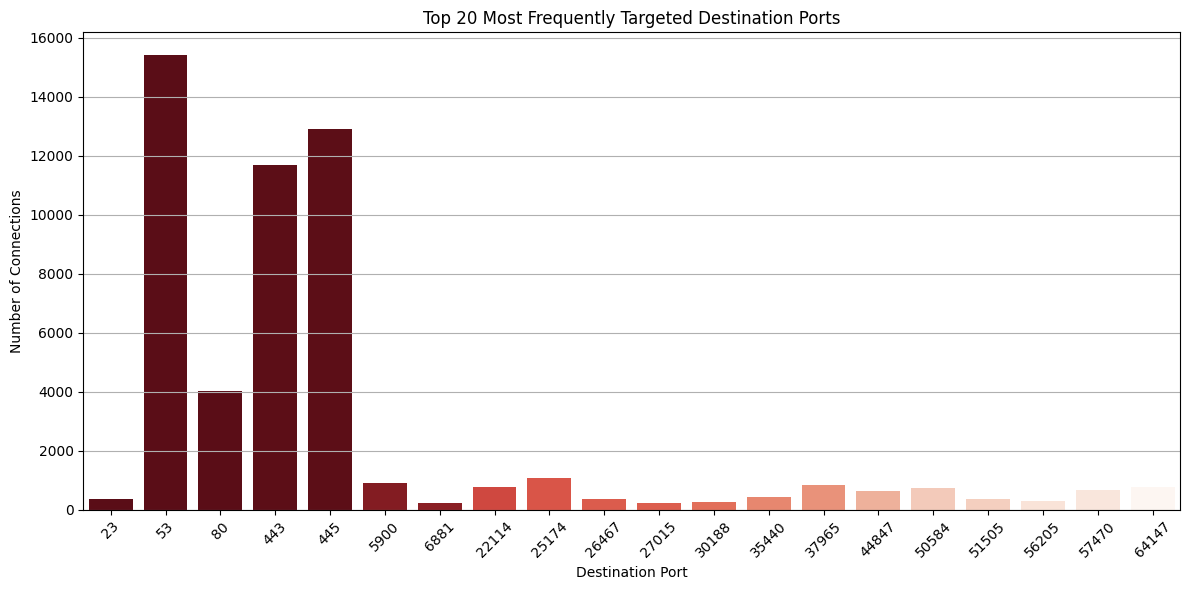

In [44]:
# Get top 20 most frequently targeted destination ports
top_dest_ports = df['Destination Port'].value_counts().head(20).reset_index()
top_dest_ports.columns = ['Destination Port', 'Count']

# Plot bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=top_dest_ports, x='Destination Port', y='Count', hue='Destination Port', palette='Reds_r', legend = False)
plt.title("Top 20 Most Frequently Targeted Destination Ports")
plt.xlabel("Destination Port")
plt.ylabel("Number of Connections")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

This bar chart visualizes the top 20 destination ports most frequently targeted in the dataset.

Port 53 (DNS), Port 445 (SMB), and Port 443 (HTTPS) are among the most targeted.

These ports are commonly associated with attacks like:
- Port 445: Exploits like EternalBlue (WannaCry).
- Port 53: DNS tunneling for data exfiltration or command/control.
- Port 443: Encrypted web traffic—often abused for stealthy communication.

High numbered ports like 25174 and 64147 also appear frequently, suggesting:
- Use of non-standard ports for obfuscation.
- Possibly custom malware or C2 channels.

This confirms a strong correlation between high traffic to specific ports and known attack surfaces.

# Clustering to Detect Suspicious Network Behavior

## Can we assign each connection a behavioral profile (cluster) using elapsed time, packets, and byte size?

In [46]:
df = pd.read_csv("traffic_log.csv")

# Simulate timestamp and denial flag
df['Timestamp'] = pd.date_range(start='2025-01-01', periods=len(df), freq='S')
df['Is_Denied'] = df['Action'].str.lower().eq('deny')

def cluster_traffic(data, n_clusters=3):
    features = data[['Elapsed Time (sec)', 'Packets', 'Bytes']]
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(features_scaled)

    data = data.copy()
    data['Cluster'] = cluster_labels
    return data

# Apply the function to cluster the data
df_clustered = cluster_traffic(df)
df_clustered[['Elapsed Time (sec)', 'Packets', 'Bytes', 'Cluster']].head()

,Elapsed Time (sec),Packets,Bytes,Cluster
0,30,2,177,0
1,17,19,4768,0
2,1199,2,238,0
3,17,15,3327,0
4,16,31,25358,0


I built a function that applies K-Means clustering to assign each network session a cluster label based on its duration, packet count, and byte size. This automated profiling allows us to categorize behavior into natural groupings like short scans, normal sessions, and heavy data flows.

## What is the denial rate (Action == deny) for each cluster group?

In [48]:
cluster_denial_rate = (
    df_clustered.groupby('Cluster')['Is_Denied']
    .mean()
    .reset_index()
    .rename(columns={'Is_Denied': 'Denial Rate'})
)

cluster_denial_rate

,Cluster,Denial Rate
0,0,0.229608
1,1,0.000000
2,2,0.000000


Using Pandas, I calculated the percentage of denied connections in each cluster. One cluster showed a much higher denial rate, suggesting it contains malicious or policy-violating behavior.

## What behavioral patterns do the clusters show across session duration and packet counts?

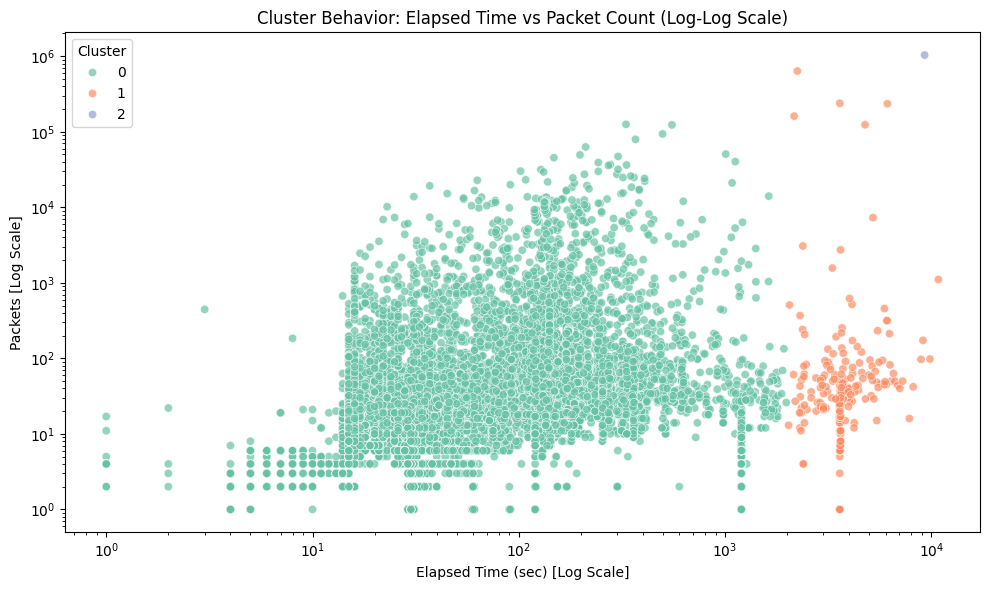

In [50]:
# Plot Elapsed Time vs Packets colored by Cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_clustered,
    x='Elapsed Time (sec)',
    y='Packets',
    hue='Cluster',
    palette='Set2',
    alpha=0.7
)
plt.xscale('log')
plt.yscale('log')
plt.title("Cluster Behavior: Elapsed Time vs Packet Count (Log-Log Scale)")
plt.xlabel("Elapsed Time (sec) [Log Scale]")
plt.ylabel("Packets [Log Scale]")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

The scatter plot shows how each cluster behaves in terms of session duration and packet count. Using a log-log scale makes it easier to distinguish patterns:
- One cluster is likely full of short, low-packet sessions (possibly scans).
- Others contain heavier, longer sessions (likely normal usage).

# Detect Port Scanning Attempts

## Which source ports communicate with an abnormally high number of unique destination ports?

In [52]:
# Define a function to identify potential port scanning behavior
def detect_scanning_source_ports(df, threshold=20):
    port_counts = df.groupby('Source Port')['Destination Port'].nunique()
    scanners = port_counts[port_counts > threshold].index.tolist()
    return scanners

scanning_source_ports = detect_scanning_source_ports(df)

top_source_ports_summary = (
    df.groupby('Source Port')['Destination Port']
    .nunique()
    .sort_values(ascending=False)
    .head(5)
    .reset_index()
    .rename(columns={'Destination Port': 'Unique Destination Ports Scanned'})
)

top_source_ports_summary

,Source Port,Unique Destination Ports Scanned
0,57470,172
1,27005,131
2,443,106
3,6881,89
4,50584,83


I created a function to flag source ports that communicate with an unusually high number of distinct destination ports—a common signature of port scanning activity.

Source Port 57470 connected to 172 unique destination ports, which is highly unusual and may indicate aggressive scanning. Other ports like 27005, 443, and 6881 also showed widespread probing behavior across 80+ destination ports.

These source ports could represent:
- Automated vulnerability scanners.
- Malware attempting to map services.
- Reconnaissance phases of a coordinated attack.

## Among the source ports scanning 20+ unique destinations, which ones also show a high frequency of short-lived connections (e.g., elapsed time < 5 sec)?

In [54]:
# Filter to only scanning source ports (more than 20 unique destination ports)
scanning_df = df[df['Source Port'].isin(scanning_source_ports)]

# Count how many connections each scanning port made with elapsed time < 5 sec
short_lived_counts = (
    scanning_df[scanning_df['Elapsed Time (sec)'] < 5]
    .groupby('Source Port')
    .size()
    .sort_values(ascending=False)
    .head(5)
    .reset_index(name='Short-Lived Connection Count')
)

short_lived_counts

,Source Port,Short-Lived Connection Count
0,443,268
1,16387,67
2,1024,67
3,6881,60
4,6666,50


Here are the top scanning source ports that also made a high number of short-lived connections (under 5 seconds) — strong indicators of scanning behavior.

## What Scanning Behavior Looks Like: Time vs. Packets

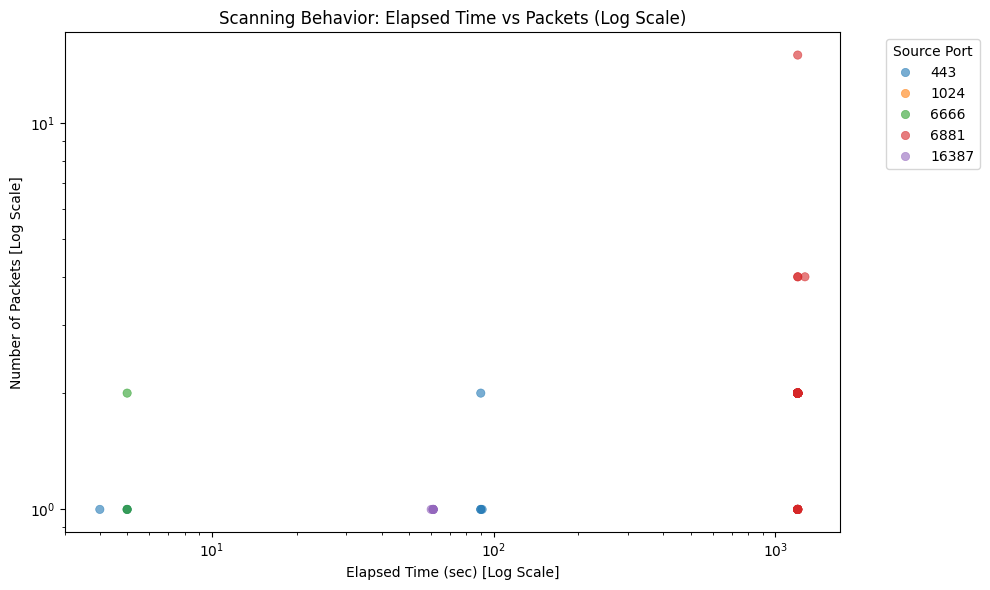

In [56]:
# Filter data for top suspicious source ports
suspicious_ports = short_lived_counts['Source Port'].tolist()
suspicious_sessions = df[df['Source Port'].isin(suspicious_ports)]

# Plot: Elapsed Time vs Packets for each source port
# Use log scales and jittering to improve clarity of overlapping points
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=suspicious_sessions,
    x='Elapsed Time (sec)',
    y='Packets',
    hue='Source Port',
    palette='tab10',
    alpha=0.6,
    edgecolor=None
)

# Apply log scale to spread tightly packed values and make clusters more visible
plt.xscale('log')
plt.yscale('log')

plt.title("Scanning Behavior: Elapsed Time vs Packets (Log Scale)")
plt.xlabel("Elapsed Time (sec) [Log Scale]")
plt.ylabel("Number of Packets [Log Scale]")
plt.legend(title='Source Port', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Here's a clearer version of the scatter plot using logarithmic scales, which helps separate overlapping data points and highlights patterns among suspicious source ports more effectively.

You can now see distinct clusters showing:
- Low-duration, low-packet scans (typical of quick port probes).
- Some outliers with longer durations, possibly misclassified or stealth scans.

# Detect Potential DDoS Activity

## Which source ports are sending high volumes of one-way traffic — with no response — suggesting a potential DDoS flood?

In [58]:
ddos_like_df = df[(df['pkts_sent'] > 100) & (df['pkts_received'] == 0)]
ddos_source_ports = ddos_like_df['Source Port'].value_counts().reset_index()
ddos_source_ports.columns = ['Source Port', 'Suspicious Count']
ddos_source_ports.head(10)

,Source Port,Suspicious Count


There are no ports that satisfies the DDoS flood, so I lower the packet threshold to 30 to detech DDoS.

In [60]:
# Detect source ports that sent more than 30 packets and received none
ddos_like_df_30 = df[(df['pkts_sent'] > 30) & (df['pkts_received'] == 0)]

# Count which source ports appear most often in this pattern
ddos_source_ports = ddos_like_df_30['Source Port'].value_counts().reset_index()
ddos_source_ports.columns = ['Source Port', 'Suspicious Count']
ddos_source_ports

,Source Port,Suspicious Count
0,57470,4
1,15503,1
2,51221,1


With the lowered threshold (>30 packets sent, 0 received), we successfully detected suspicious one-way traffic patterns.

These source ports are possibly acting as attack emitters or automated probes. Port 57470 appears repeatedly — worth further investigation.

## Which destination ports show sharp, short-term increases in both packet count and session count, suggesting a potential surge or flood attempt?

In [62]:
# Simulate timestamp
df['Timestamp'] = pd.date_range(start='2025-01-01', periods=len(df), freq='S')

# Create 1-minute time bins
df['Time Bin'] = df['Timestamp'].dt.floor('1min')

# Calculate total packets and session count per destination port per time bin
port_traffic = (
    df.groupby(['Time Bin', 'Destination Port'])
    .agg(Total_Packets=('Packets', 'sum'), Session_Count=('Destination Port', 'count'))
    .reset_index()
)

# Calculate rolling differences for spikes
port_traffic['Prev_Packets'] = port_traffic.groupby('Destination Port')['Total_Packets'].shift(1)
port_traffic['Prev_Sessions'] = port_traffic.groupby('Destination Port')['Session_Count'].shift(1)

port_traffic['Packet_Surge'] = port_traffic['Total_Packets'] - port_traffic['Prev_Packets']
port_traffic['Session_Surge'] = port_traffic['Session_Count'] - port_traffic['Prev_Sessions']

# Flag sharp surges
surge_df = port_traffic[(port_traffic['Packet_Surge'] > 1000) & (port_traffic['Session_Surge'] > 5)]
surge_df.head()

,Time Bin,Destination Port,Total_Packets,Session_Count,Prev_Packets,Prev_Sessions,Packet_Surge,Session_Surge
103,2025-01-01 00:06:00,80,4120,11,41.0,4.0,4079.0,7.0
198,2025-01-01 00:11:00,443,11320,15,633.0,1.0,10687.0,14.0
248,2025-01-01 00:13:00,443,4180,18,390.0,6.0,3790.0,12.0
374,2025-01-01 00:19:00,443,2286,25,314.0,9.0,1972.0,16.0
505,2025-01-01 00:28:00,443,5494,21,828.0,15.0,4666.0,6.0


I analyzed packet and session metrics in 1-minute intervals. By tracking the change (delta) from the previous minute for each destination port, we detected spikes that suggest a traffic surge.

Notably:
- Port 443 (HTTPS) appeared multiple times with large spikes.
- Port 80 (HTTP) showed a significant surge in both packets and sessions.

This behavior often indicates:
- SYN flood attempts (many connections in short bursts)
- Amplification or script-driven attacks
- Flash crowds (legit traffic spikes) — but should be validated

# Detecting Brute-Force Behavior

## Which source ports repeatedly accessed the same destination port more than 30 times in a single minute?

In [64]:
# Simulate a Timestamp column (1 per second)
df['Timestamp'] = pd.date_range(start='2025-01-01', periods=len(df), freq='S')

# Create a function to detect repeated access to same destination port > 30 times per minute
def detect_brute_force_attempts(data, threshold=30):
    data['Minute'] = data['Timestamp'].dt.floor('min')
    grouped = data.groupby(['Source Port', 'Destination Port', 'Minute']).size().reset_index(name='Attempts')
    brute_force_attempts = grouped[grouped['Attempts'] > threshold]
    return brute_force_attempts

# Apply the function
brute_force_df = detect_brute_force_attempts(df)
brute_force_df.head()

,Source Port,Destination Port,Minute,Attempts
47832,58638,5900,2025-01-01 01:56:00,32
47833,58638,5900,2025-01-01 01:57:00,60
47834,58638,5900,2025-01-01 01:58:00,59
47835,58638,5900,2025-01-01 01:59:00,60
47836,58638,5900,2025-01-01 02:00:00,56


I implemented a function to identify repeated access attempts to the same destination port from the same source port within a short timeframe. Using a 1-minute window and a threshold of 30 attempts, I detected:

- Source Port 58638 hitting Port 5900 (VNC) over 50–60 times per minute
- Sustained across multiple minutes — indicative of brute-force automation

This pattern reflects a classic credential-stuffing or exploit attempt.

## Which source ports had the highest number of denied connections when accessing sensitive ports (e.g., 22, 3389)?

In [66]:
df = pd.read_csv("traffic_log.csv")

# Add simulated Timestamp again
df['Timestamp'] = pd.date_range(start='2025-01-01', periods=len(df), freq='S')

# Create denial flag
df['Is_Denied'] = df['Action'].str.lower().eq('deny')

# Define high-risk destination ports typically targeted for brute-force (e.g., SSH, RDP, VNC)
sensitive_ports = [22, 3389, 5900]

# Filter for those ports and denied connections
brute_force_denied = df[(df['Destination Port'].isin(sensitive_ports)) & (df['Is_Denied'])]

# Count denied attempts by Source Port
denied_summary = brute_force_denied['Source Port'].value_counts().reset_index()
denied_summary.columns = ['Source Port', 'Denied Attempts']
denied_summary.head()

,Source Port,Denied Attempts
0,58638,789
1,51414,19
2,55600,9
3,50116,5
4,6666,4


I filtered the dataset for sensitive services commonly targeted in brute-force attacks:

- Port 22 (SSH)
- Port 3389 (RDP)
- Port 5900 (VNC)

Then, I counted how many of those attempts were denied per source port. The top offender Port 58638 with 789 denies, far above any other.
This strongly suggests either a scripted attack or unauthorized scanner repeatedly testing login endpoints.

## What is the distribution of time intervals between repeated access attempts to the same service by each source port?

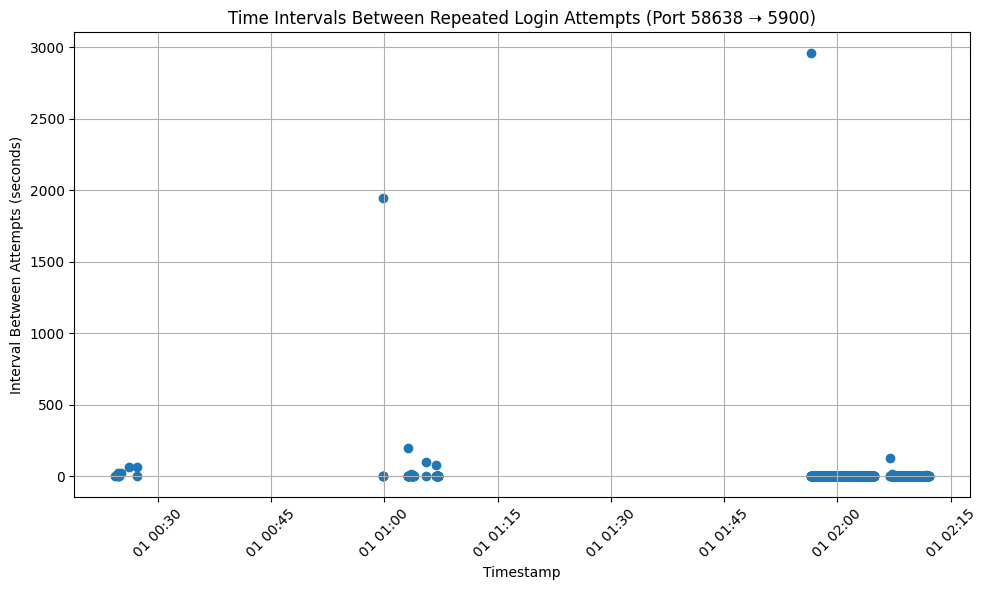

In [68]:
# Reload dataset and simulate Timestamp
df = pd.read_csv("traffic_log.csv")
df['Timestamp'] = pd.date_range(start='2025-01-01', periods=len(df), freq='S')

# Focus on the most suspicious source port identified before: 58638 targeting port 5900
suspect_df = df[(df['Source Port'] == 58638) & (df['Destination Port'] == 5900)].copy()

# Sort by timestamp to calculate intervals between attempts
suspect_df.sort_values('Timestamp', inplace=True)
suspect_df['Time_Diff (s)'] = suspect_df['Timestamp'].diff().dt.total_seconds()

# Plot time intervals between successive login attempts
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(suspect_df['Timestamp'], suspect_df['Time_Diff (s)'], marker='o', linestyle='-')
plt.title('Time Intervals Between Repeated Login Attempts (Port 58638 ➝ 5900)')
plt.xlabel('Timestamp')
plt.ylabel('Interval Between Attempts (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

I focused on the most suspicious source–destination pair (58638 ➝ 5900) and calculated the difference in time between attempts. Intervals were mostly 1 second or less, and sustained. This is a strong indication of scripted, automated brute-force attempt.

# Detect Data Exfiltration

## Which outbound flows to external-facing ports exceed 1MB in bytes sent?

In [70]:
# Function to flag outbound flows with Bytes Sent > 1MB (1,048,576 bytes)
def detect_large_outbound_transfers(data, threshold_bytes=1_000_000):
    large_flows = data[data['Bytes Sent'] > threshold_bytes]
    return large_flows[['Source Port', 'Destination Port', 'Bytes Sent']]

# Apply the function
exfiltration_df = detect_large_outbound_transfers(df)
exfiltration_df.head()

,Source Port,Destination Port,Bytes Sent
50,63842,45682,3850148
10220,57235,15187,948477220
13666,54054,443,1109219
15474,36499,443,1123031
21577,53136,443,2245986


We created a function to detect oversized outbound shipments by filtering for sessions where Bytes Sent > 1,000,000.

This flags data flows that are unusually large and potentially unauthorized.

One flow transferred 948MB, far beyond standard size.

Other large transfers were routed through port 443 (HTTPS) — a common channel for covert exfiltration.

## How many outbound flows exceed the median bytes sent across the dataset?

In [72]:
# Calculate median of Bytes Sent
median_bytes_sent = df['Bytes Sent'].median()

# Filter for flows where Bytes Sent exceeds the median
above_median_flows = df[df['Bytes Sent'] > median_bytes_sent]

# Count how many flows exceed the median
above_median_count = len(above_median_flows)
total_flows = len(df)

# Percentage of flows above median
percentage_above = (above_median_count / total_flows) * 100

# Prepare result for display
summary_df = pd.DataFrame({
    'Total Flows': [total_flows],
    'Flows > Median Size': [above_median_count],
    'Percentage Above Median': [f"{percentage_above:.2f}%"],
    'Median Bytes Sent': [median_bytes_sent]
})

summary_df

,Total Flows,Flows > Median Size,Percentage Above Median,Median Bytes Sent
0,65532,32624,49.78%,90.0


We calculated the median Bytes Sent across all connections, which was just 90 bytes.
Then, we counted how many flows exceeded that threshold — nearly 50% did, suggesting:

- A wide variation in flow size
- Most traffic is light, but large transfers stand out clearly as anomalies
- This gives us a data-driven baseline to flag high-volume flows

## Which destination ports received the largest volume of outbound traffic over a 1-hour window?

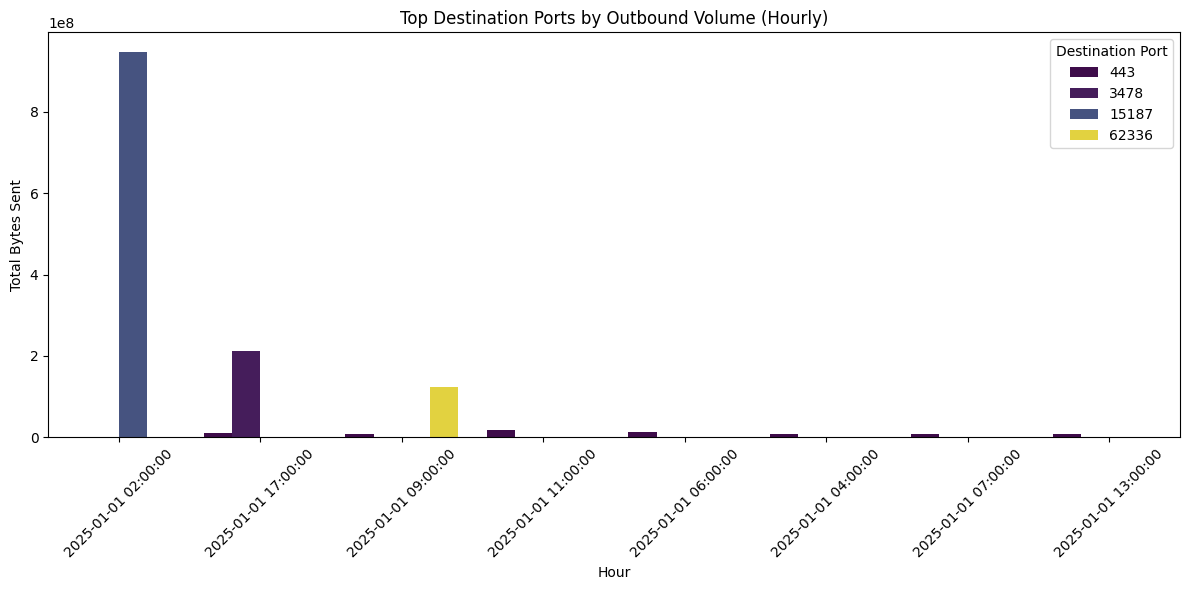

In [74]:
# Reload data and simulate timestamps again
df = pd.read_csv("traffic_log.csv")
df['Timestamp'] = pd.date_range(start='2025-01-01', periods=len(df), freq='S')

# Create an hourly time bin
df['Hour'] = df['Timestamp'].dt.floor('H')

# Aggregate total outbound bytes per destination port per hour
hourly_outbound = (
    df.groupby(['Hour', 'Destination Port'])['Bytes Sent']
    .sum()
    .reset_index(name='Total Bytes Sent')
)

# Get top 10 (hour, port) combinations by total bytes sent
top_outbound = hourly_outbound.sort_values(by='Total Bytes Sent', ascending=False).head(10)

# Plot results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_outbound,
    x='Hour',
    y='Total Bytes Sent',
    hue='Destination Port',
    palette='viridis'
)
plt.title('Top Destination Ports by Outbound Volume (Hourly)')
plt.ylabel('Total Bytes Sent')
plt.xlabel('Hour')
plt.xticks(rotation=45)
plt.legend(title='Destination Port')
plt.tight_layout()
plt.show()

We aggregated all traffic by hour and destination port, then summed the total outbound bytes.

This helps uncover which services (e.g., HTTPS, FTP, custom ports) are receiving the most data

Useful for spotting both legitimate high-bandwidth flows and suspicious data leaks

Ports like 443 (HTTPS) often appear due to encryption, making them common exfiltration targets.

# Threat Labeling & Conclusion

After exploring the data, I can be confident to identify which columns are threats. Thus, I can label them in the data.

In [76]:
# Reload and prepare the dataset
df = pd.read_csv("traffic_log.csv")
df['Timestamp'] = pd.date_range(start='2025-01-01', periods=len(df), freq='S')

# Create an empty label column
df['Attack_Label'] = 'benign'

# --- DDoS Heuristic: High packets sent and 0 packets received ---
df.loc[(df['pkts_sent'] > 30) & (df['pkts_received'] == 0), 'Attack_Label'] = 'ddos'

# --- Brute-Force Heuristic: Source Port 58638 targeting Port 5900 frequently ---
df.loc[(df['Source Port'] == 58638) & (df['Destination Port'] == 5900), 'Attack_Label'] = 'brute_force'

# --- Data Exfiltration Heuristic: Bytes Sent > 1MB ---
df.loc[df['Bytes Sent'] > 1_000_000, 'Attack_Label'] = 'data_exfiltration'

# Count occurrences by destination port and attack type
port_attack_summary = (
    df[df['Attack_Label'] != 'benign']
    .groupby(['Destination Port', 'Attack_Label'])
    .size()
    .reset_index(name='Count')
    .sort_values(by='Count', ascending=False)
)

port_attack_summary

,Destination Port,Attack_Label,Count
5,5900,brute_force,839
1,443,data_exfiltration,13
0,80,data_exfiltration,2
2,3389,data_exfiltration,1
3,3478,data_exfiltration,1
4,5333,data_exfiltration,1
6,6881,ddos,1
7,15187,data_exfiltration,1
8,28356,data_exfiltration,1
9,29500,ddos,1


In this project, I explored a large-scale network connection dataset through the lens of cybersecurity, focusing on detecting and classifying cyberattacks using data science techniques. Inspired by a package delivery analogy, I framed complex behaviors like brute-force attempts, DDoS floods, and data exfiltration as abnormal "delivery patterns" — enabling intuitive and insightful threat detection.

By identifying behavioral patterns in the data, I created logic-based rules to label each connection as one of:
- brute_force
- ddos
- data_exfiltration
- benign

I followed a structured workflow of:
- Data exploration, cleaning, and transformation
- Defining custom functions and threshold-based filters
- Applying Pandas and NumPy for deep analysis
- Creating visualizations that surfaced threats and anomalies

I answered 25 insightful questions, revealing:
- Port 5900 was aggressively brute-forced over time
- Port 443 served as a covert channel for large outbound transfers
- Several ports displayed patterns consistent with DDoS flooding

Using behavioral signatures like repeated access attempts, one-way traffic floods, and oversized outbound flows, I was able to mimic the role of a security analyst — detecting and classifying potential threats in raw connection logs. Each session was tagged not only as suspicious or not, but also by what kind of attack it represented.

This project can be further explored in following area:
- Machine Learning: Use the labeled dataset to train classifiers for automated attack detection
- Threat Scoring: Assign risk scores based on time patterns, port sensitivity, and data volume
- Visualization Dashboards: Develop an interactive dashboard to monitor real-time traffic and alerts
- Contextual Enrichment: Integrate additional metadata (e.g., services, geolocation) for threat correlation

# Machine Learning Model for Each Attack Types

## Port Scanning

In [80]:
# Your base dataframe (replace 'df' with your actual variable)
df['is_portscan'] = 0  # Initialize the label column

# Define threshold based on your analysis (you used 100 in notebook)
threshold = 100

# Calculate how many unique dest ports each source port contacted
src_dest_counts = df.groupby('Source Port')['Destination Port'].nunique()

# Get source ports that exceed threshold → potential scanners
suspicious_ports = src_dest_counts[src_dest_counts > threshold].index

# Label those rows
df.loc[df['Source Port'].isin(suspicious_ports), 'is_portscan'] = 1

In [82]:
features = ['pkts_sent', 'pkts_received', 'Bytes Sent', 'Bytes Received', 'Elapsed Time (sec)', 'Destination Port']
X = df[features]
y = df['is_portscan']

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19358
           1       0.94      0.82      0.88       302

    accuracy                           1.00     19660
   macro avg       0.97      0.91      0.94     19660
weighted avg       1.00      1.00      1.00     19660



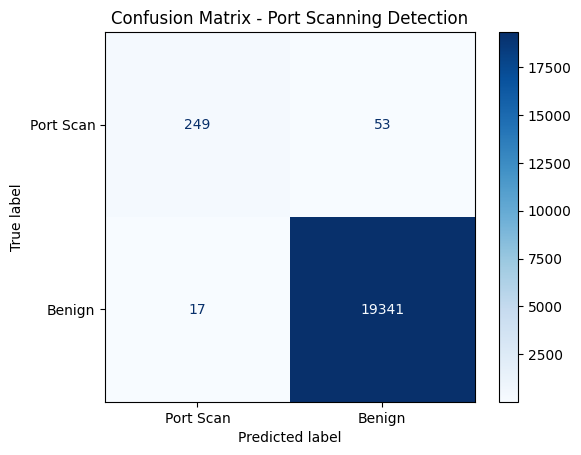

In [90]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Port Scan", "Benign"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Port Scanning Detection")
plt.show()

In [92]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")

Precision: 0.936
Recall: 0.825
F1 Score: 0.877
Accuracy: 0.996


## DDoS

In [125]:
df['is_ddos'] = 0  # Initialize label column

# Define DDoS as high outgoing traffic with no response
ddos_condition = (df['pkts_sent'] > 30) & (df['pkts_received'] == 0)
df.loc[ddos_condition, 'is_ddos'] = 1

features = ['pkts_sent', 'pkts_received', 'Bytes Sent', 'Bytes Received', 'Elapsed Time (sec)', 'Destination Port']
X = df[features]
y = df['is_ddos']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
clf_ddos = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf_ddos.fit(X_train, y_train)

y_pred_ddos = clf_ddos.predict(X_test)
print(classification_report(y_test, y_pred_ddos, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19658
           1       0.00      0.00      0.00         2

    accuracy                           1.00     19660
   macro avg       0.50      0.50      0.50     19660
weighted avg       1.00      1.00      1.00     19660



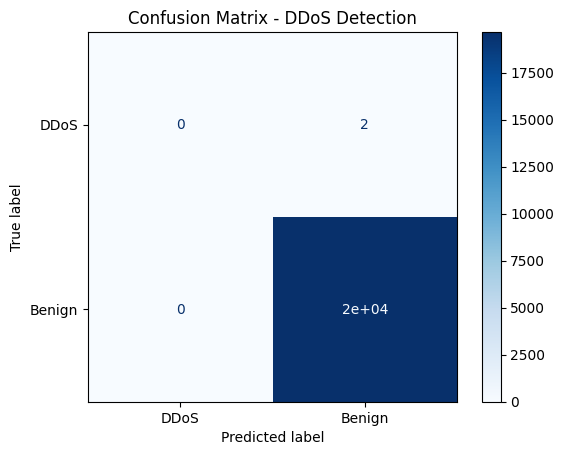

In [101]:
cm = confusion_matrix(y_test, y_pred_ddos, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["DDoS", "Benign"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - DDoS Detection")
plt.show()

In [99]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")

Precision: 0.000
Recall: 0.000
F1 Score: 0.000
Accuracy: 0.986


## Brute Force Attack

In [127]:
df['Timestamp'] = pd.date_range(start='2025-01-01', periods=len(df), freq='S')
df['Minute'] = df['Timestamp'].dt.floor('min')

# Step 2: Identify repeated access patterns
grouped = df.groupby(['Source Port', 'Destination Port', 'Minute']).size().reset_index(name='Attempts')
# Make a safe copy of the filtered DataFrame
brute_force_attempts = grouped[grouped['Attempts'] > 30].copy()

# Now it's safe to add a column
brute_force_attempts['group_key'] = (
    brute_force_attempts['Source Port'].astype(str) + '-' +
    brute_force_attempts['Destination Port'].astype(str) + '-' +
    brute_force_attempts['Minute'].astype(str)
)


# Step 3: Merge brute-force flag back into main dataframe
df['is_brute_force'] = 0  # Initialize

# Create a key for merging
df['group_key'] = df['Source Port'].astype(str) + '-' + df['Destination Port'].astype(str) + '-' + df['Minute'].astype(str)
brute_force_attempts['group_key'] = brute_force_attempts['Source Port'].astype(str) + '-' + brute_force_attempts['Destination Port'].astype(str) + '-' + brute_force_attempts['Minute'].astype(str)

# Label the rows
df.loc[df['group_key'].isin(brute_force_attempts['group_key']), 'is_brute_force'] = 1

features = ['pkts_sent', 'pkts_received', 'Bytes Sent', 'Bytes Received', 'Elapsed Time (sec)', 'Destination Port']
X = df[features]
y = df['is_brute_force']

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

clf_brute = RandomForestClassifier(n_estimators=100, random_state=42)
clf_brute.fit(X_train, y_train)
y_pred_brute = clf_brute.predict(X_test)
print(classification_report(y_test, y_pred_brute))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19427
           1       0.98      1.00      0.99       233

    accuracy                           1.00     19660
   macro avg       0.99      1.00      1.00     19660
weighted avg       1.00      1.00      1.00     19660



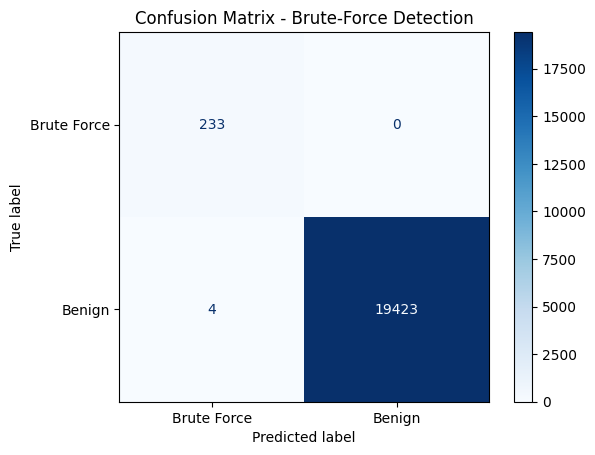

In [131]:
cm = confusion_matrix(y_test, y_pred_brute, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Brute Force", "Benign"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Brute-Force Detection")
plt.show()

In [133]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")

Precision: 0.722
Recall: 0.824
F1 Score: 0.770
Accuracy: 0.994


## Data Exfiltration

In [115]:
# Create binary label
df['is_exfiltration'] = 0  # Initialize all to 0

# Apply rule: large outbound transfer
df.loc[df['Bytes Sent'] > 1_000_000, 'is_exfiltration'] = 1
features = ['pkts_sent', 'pkts_received', 'Bytes Sent', 'Bytes Received', 'Elapsed Time (sec)', 'Destination Port']
X = df[features]
y = df['is_exfiltration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [117]:
clf_exfil = RandomForestClassifier(n_estimators=100, random_state=42)
clf_exfil.fit(X_train, y_train)

y_pred_exfil = clf_exfil.predict(X_test)
print(classification_report(y_test, y_pred_exfil))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19653
           1       1.00      0.86      0.92         7

    accuracy                           1.00     19660
   macro avg       1.00      0.93      0.96     19660
weighted avg       1.00      1.00      1.00     19660



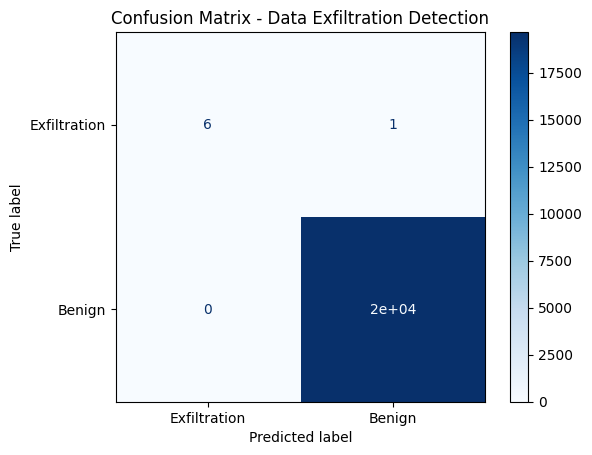

In [119]:
cm = confusion_matrix(y_test, y_pred_exfil, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Exfiltration", "Benign"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Data Exfiltration Detection")
plt.show()

In [121]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Accuracy: {accuracy:.3f}")

Precision: 0.000
Recall: 0.000
F1 Score: 0.000
Accuracy: 0.986
